## Cleaning & Transforming the Kaggle Dataset be seen [here](https://colab.research.google.com/drive/1nWSHRtgpOhtSF6VMhLXnJsyWB2moqjQ5?usp=sharing)


## Cleaning & Transforming the IMDB Dataset be seen [here](https://colab.research.google.com/drive/1iczkp6OkZtiGzRdiaiB4D30NGewxgrjk?usp=sharing)


## Recommender Attempt #1: Utilizing Clustering Algorithms to recommended movies based on closest points within the cluster the movie is classified as can be seen [here](https://colab.research.google.com/drive/1oWfdUSnlQYqnu36QEaoj8O9TBMTKBd3X?usp=sharing)

## Recommender Attempt #2: Utilizing KNN to recommend similarly rated movie [here](https://colab.research.google.com/drive/19Yeb_ZARLEcNyPgnRcTjiv8EWJ6KpXWf?usp=sharing)


## Recommender Attempt #3: Using KDTree and NNDescent to recommend movies based on the IMDB Dataset [here](https://colab.research.google.com/drive/1hpNbTIdXRIJH9RZXerFk9mSEKXXYSsXy?usp=sharing)


#Final Attempt: Utilizing KDTree and UMAP to recommend movies based on the Kaggle Dataset

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 1.2MB 6.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=12fe1f7c05ce948fae35e8a507a1a513fec50cde96259ddbba19c6b3d681f13d
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=129100eb4745d3195ef6a12f072b6b5a664c6150b2134883a77dda399a4dfc23
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KDTree
from pynndescent import NNDescent

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
output_notebook()

#### Download the cleaned and transformed Kaggle Dataset for use in the recommendation system

In [ ]:
!gdown --id 1q3_jJmGt2ehOtq1YeljzR3aMN49w94dJ #KaggleMovies.csv

Downloading...
From: https://drive.google.com/uc?id=1q3_jJmGt2ehOtq1YeljzR3aMN49w94dJ
To: /content/KaggleMovies.csv
3.83MB [00:00, 60.6MB/s]


#### Read in the dataset

In [ ]:
df = pd.read_csv("/content/KaggleMovies.csv")

In [ ]:
df.head()

,id,keywords,adult,original_language,popularity,revenue,vote_average,vote_count,castNum,genreNum,titleNum,title
0,862,2.732882,0,17,21.946943,373554033.0,7.7,5415.0,1629167,2147,894,toy story
1,8844,3.245939,0,17,17.015539,262797249.0,6.9,2413.0,12868921,2278,719,jumanji
2,15602,2.430012,0,17,11.712900,0.0,6.5,92.0,64590,1318,1483,grumpier old men
3,31357,2.852449,0,17,3.859495,81452156.0,6.1,34.0,1467529,1803,1614,waiting to exhale
4,11862,3.213356,0,17,8.387519,76578911.0,5.7,173.0,1083159,609,2336,father of the bride part ii


In [ ]:
df.shape

(45429, 12)

#### Normalize the data

In [ ]:
ss = MinMaxScaler()
df2 = ss.fit_transform(df[['keywords',	'adult',	'original_language',	'popularity',	'revenue',	'vote_average',	'vote_count',	'castNum',	'genreNum',	'titleNum']])

## KNN

### Find true nearest neighbours using KDTree to compare against the much faster NNDescent

#### Use KDTree to fit the data to binary trees

In [ ]:
 %%time
 treeIndex = KDTree(df2, leaf_size=2)

CPU times: user 1.47 s, sys: 1.53 ms, total: 1.47 s
Wall time: 1.47 s


#### Query each row of the dataset (aka each movie in the dataset) and find its 10 nearest neighbours

In [ ]:
%%time
neighbours = treeIndex.query(df2, k=11)[1] #k is equal to 11 because the query returns the initial query node

CPU times: user 6.87 s, sys: 4.73 ms, total: 6.87 s
Wall time: 6.89 s


In [ ]:
neighbours

array([[    0, 14820,  4755, ...,    46,  7270, 11313],
       [    1, 22883, 19815, ..., 13576, 18084, 39657],
       [    2,  1689,  4787, ..., 11405, 42953, 13372],
       ...,
       [45426, 17554, 27893, ..., 15061, 27329, 23261],
       [45427, 42188, 24960, ..., 27412, 40690, 33389],
       [45428, 36983, 45050, ..., 29398, 37317,  5766]])

#### Use NNDescent to fit the data to binary trees using parallelism for faster performance with large datasets

In [ ]:
%%time
index = NNDescent(df2, n_neighbors=15, diversify_prob=0.0)
index.prepare()

CPU times: user 42.4 s, sys: 324 ms, total: 42.7 s
Wall time: 39.4 s


In [ ]:
%%time
top10near = index.query(df2, k=11, epsilon=0.2)[0]
top10near

CPU times: user 563 ms, sys: 2.42 ms, total: 565 ms
Wall time: 565 ms


#### Check the accurancy of NNDescent when compared against the slower but more accurate KDTree

In [ ]:
def NNDesaccuracy(top10near, neighbours):
    result = np.zeros(top10near.shape[0])
    for i in range(top10near.shape[0]):
        n_correct = np.intersect1d(top10near[i], neighbours[i]).shape[0]
        result[i] = n_correct / neighbours.shape[1]
    return result

In [ ]:
accuracy_stats = NNDesaccuracy(top10near, neighbours)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Average accuracy of 0.9997318492993061


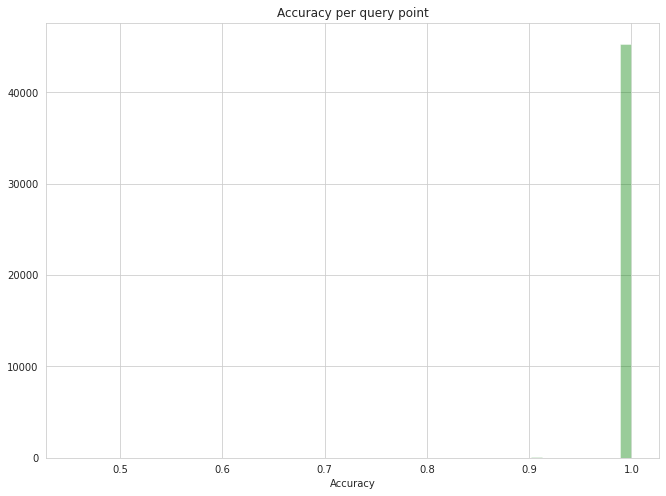

In [ ]:
plt.figure(figsize=(11,8))
sns.set_style('whitegrid')
ax = sns.distplot(accuracy_stats, kde=False, color="g") 
ax.set_title("Accuracy per query point")
ax.set_xlabel("Accuracy")
    
print(f"Average accuracy of {np.mean(accuracy_stats)}")

The accuracy score of 0.99 means that the results of the NNDescent algorithm is almost the same as that of KDTree but with faster querying, this was achieved by parameter tuning.

#### Find the 10 recommendations for a movie entered by a user (Internal Testing)

In [ ]:
# This function takes the movie title entered by the user then locates the title in the original dataframe and returns the index where the title was found. 
# The index value is then used to extract the row in the NNDescent neighest neighbours results.
# Each value in the NNDescent results row represents an index in the original dataframe, as such each index is then used to extract the title for that index and the titles are returned.
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[top10near[a[0][0]][1:]].title

In [ ]:
# Users enter a movie title to find its nearest neighbours
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: iron man


4862     the lord of the rings: the fellowship of the ring
22863                                         interstellar
26534                                   mad max: fury road
18236                                     the hunger games
23735                              guardians of the galaxy
20820                                           iron man 3
4765              harry potter and the philosopher's stone
15474                                            inception
26545                                             deadpool
19253                                              skyfall
Name: title, dtype: object

#### Output the recommendations to csv for use on Streamlit (Optional), uncomment code if needed

In [ ]:
# def myfunc(row):
#     return df.iloc[row].title

# myfunc_vec = np.vectorize(myfunc)
# top10nearTitles = myfunc_vec(top10near)
# top10nearTitles

In [ ]:
# movieRec = pd.DataFrame(top10nearTitles)
# movieRec = movieRec.rename(columns={0: 'Movie', 1: 'Rec1', 2: 'Rec2', 3: 'Rec3', 4: 'Rec4', 5: 'Rec5', 6: 'Rec6', 7: 'Rec7', 8: 'Rec8', 9: 'Rec9', 10: 'Rec10'})
# movieRec.head()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# movieRec.to_csv('/content/drive/My Drive/Big Data Project/data/MovieRecs.csv', index=False)

## KNN PCA

### KKN was attempted with the use of PCA to determine if better recommendations could be provided.

In [ ]:
# Reduce the dataset from 10 dimensions to 2 dimensions using PCA
pca = PCA(n_components=2)
df3 = pca.fit_transform(df2)

In [ ]:
df3

array([[-0.23192234, -0.13211308],
       [-0.15622993, -0.13034247],
       [-0.08615236, -0.07954386],
       ...,
       [ 0.19549707, -0.03453882],
       [ 0.59593223,  0.04965568],
       [ 0.59611978,  0.04972832]])

In [ ]:
# Fit the data to binary trees using NNDescent
index2 = NNDescent(df3)

In [ ]:
#Query the dataset to find each movie's nearest neighbours
top10near2 = index2.query(df3, k=11)[0]
top10near2

array([[    0,  4747,   600, ..., 21163, 32156, 12178],
       [    1,  7385,  7809, ...,  4339, 19826, 16110],
       [    2,   229, 25813, ..., 17544, 16070,  7538],
       ...,
       [45426, 17554, 20972, ..., 44338, 34315, 35777],
       [45427,   820, 18032, ..., 33887, 28463, 37424],
       [45428, 32017, 44299, ..., 34448, 37162, 21434]], dtype=int32)

In [ ]:
def getNearest(value):
  a = np.where(df['title'].values == value.lower())
  return  df.iloc[top10near2[a[0][0]]].title

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: iron man


4862     the lord of the rings: the fellowship of the ring
22863                                         interstellar
26534                                   mad max: fury road
18236                                     the hunger games
23735                              guardians of the galaxy
20820                                           iron man 3
4765              harry potter and the philosopher's stone
15474                                            inception
26545                                             deadpool
19253                                              skyfall
Name: title, dtype: object

## UMAP KNN

#### UMAP was used as an alternative to PCA for dimension reduction

In [ ]:
# Reduce the dimensions from 10 attributes to 2, and set a random state so that recommendations are always the same regardless of the number of times UMAP is computed.
%%time
df4 = umap.UMAP(n_components=2, random_state=72).fit_transform(df2)

CPU times: user 1min 39s, sys: 3.46 s, total: 1min 42s
Wall time: 1min 28s


In [ ]:
df4

array([[ 5.3016634,  3.1523895],
       [ 6.017281 ,  2.569158 ],
       [ 4.6709976, -1.5137672],
       ...,
       [ 9.488307 , 16.318157 ],
       [21.99965  ,  4.8900146],
       [22.448328 ,  3.4190915]], dtype=float32)

In [ ]:
%%time
treeIndex = KDTree(df4, leaf_size=2)

CPU times: user 37.4 ms, sys: 15 µs, total: 37.4 ms
Wall time: 41.1 ms


In [ ]:
%%time
neighbours = treeIndex.query(df4, k=11)[1]

CPU times: user 190 ms, sys: 1.98 ms, total: 192 ms
Wall time: 193 ms


In [ ]:
neighbours

array([[    0,  3455,    46, ...,   314, 23448, 26550],
       [    1, 42202, 10410, ..., 26538, 18965,  8306],
       [    2, 17203, 35803, ...,  8320, 12871,  2846],
       ...,
       [45426, 35162, 17554, ..., 15273, 26899, 13342],
       [45427, 42188, 34264, ..., 39243, 31371, 33389],
       [45428, 21486, 30369, ..., 38174, 29398, 37524]])

In [ ]:
%%time
index3 = NNDescent(df4, n_neighbors=15, diversify_prob=0.0)
index3.prepare()

CPU times: user 8.77 s, sys: 75.3 ms, total: 8.85 s
Wall time: 5.85 s


In [ ]:
%%time
top10near3 = index3.query(df4, k=11, epsilon=0.2)[0]

CPU times: user 270 ms, sys: 903 µs, total: 271 ms
Wall time: 269 ms


In [ ]:
top10near3

array([[    0,  3455,    46, ...,   314, 23448, 26550],
       [    1, 42202, 10410, ..., 26538, 18965,  8306],
       [    2, 17203, 35803, ...,  8320, 12871,  2846],
       ...,
       [45426, 35162, 17554, ..., 15273, 26899, 13342],
       [45427, 42188, 34264, ..., 39243, 31371, 33389],
       [45428, 21486, 30369, ..., 38174, 29398, 37524]], dtype=int32)

In [ ]:
def NNDesaccuracy(top10near, neighbours):
    result = np.zeros(top10near.shape[0])
    for i in range(top10near.shape[0]):
        n_correct = np.intersect1d(top10near[i], neighbours[i]).shape[0]
        result[i] = n_correct / neighbours.shape[1]
    return result

In [ ]:
accuracy_stats = NNDesaccuracy(top10near3, neighbours)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Average accuracy of 0.9999979988753679


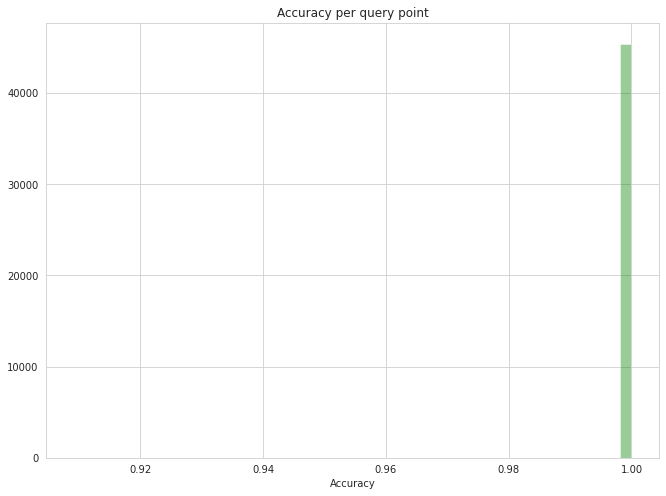

In [ ]:
plt.figure(figsize=(11,8))
sns.set_style('whitegrid')
ax = sns.distplot(accuracy_stats, kde=False, color="g") 
ax.set_title("Accuracy per query point")
ax.set_xlabel("Accuracy")
    
print(f"Average accuracy of {np.mean(accuracy_stats)}")

There does not seem to be a clear performance benefit to using NNDescent, therefore KDTree shall be used for the recommendation system

### Utilizing Bokeh to plot the UMAP'd dataset

In [ ]:
movies_df = pd.DataFrame(df4, columns=('x', 'y'))
movies_df['title'] = df['title'].values

datasource = ColumnDataSource(movies_df)


plt_figure = figure(
    title='UMAP for the movies dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plt_figure.add_tools(HoverTool(tooltips=[
            ('Title', '@title'),
           ]))

plt_figure.circle(
    'x',
    'y',
    source=datasource,
)

show(plt_figure)


In [ ]:
def myfunc(row):
    return df.iloc[row].title

myfunc_vec = np.vectorize(myfunc)
top10nearTitles = myfunc_vec(neighbours)
top10nearTitles

array([['toy story', 'gladiator', 'se7en', ...,
        'the shawshank redemption', 'edge of tomorrow',
        'x-men: apocalypse'],
       ['jumanji', 'the boss baby', 'kiss kiss bang bang', ...,
        'warcraft', 'snow white and the huntsman', 'sherlock, jr.'],
       ['grumpier old men', 'he ran all the way',
        'plastic galaxy: the story of star wars toys', ...,
        'sadie thompson', 'elegy', 'joe the king'],
       ...,
       ['betrayal', 'the unwanted', "bear's kiss", ...,
        'the wedding weekend', 'mayor cupcake', 'game over'],
       ['satan triumphant', 'for love or money', 'dombivali fast', ...,
        'golden mouth', 'stonemouth', 'the pie-covered wagon'],
       ['queerama', 'so it goes', 'the drunk', ..., 'lamerica',
        'aging out', 'let him be']], dtype='<U105')

In [ ]:
movieRec = pd.DataFrame(top10nearTitles)
movieRec = movieRec.rename(columns={0: 'Movie', 1: 'Rec1', 2: 'Rec2', 3: 'Rec3', 4: 'Rec4', 5: 'Rec5', 6: 'Rec6', 7: 'Rec7', 8: 'Rec8', 9: 'Rec9', 10: 'Rec10'})
movieRec.head()

,Movie,Rec1,Rec2,Rec3,Rec4,Rec5,Rec6,Rec7,Rec8,Rec9,Rec10
0,toy story,gladiator,se7en,gone girl,shutter island,300,the imitation game,despicable me,the shawshank redemption,edge of tomorrow,x-men: apocalypse
1,jumanji,the boss baby,kiss kiss bang bang,fifty shades of grey,brother bear,match point,hansel & gretel: witch hunters,lucky number slevin,warcraft,snow white and the huntsman,"sherlock, jr."
2,grumpier old men,he ran all the way,plastic galaxy: the story of star wars toys,love is colder than death,bobby,vision quest,cleanflix,the ritz,sadie thompson,elegy,joe the king
3,waiting to exhale,under suspicion,last chance harvey,the girl from the song,šíleně smutná princezna,solace,tokyo joe,sleeping with the enemy,the groundstar conspiracy,teen beach 2,dream for an insomniac
4,father of the bride part ii,the curiosity of chance,bad influence,angels one five,tall in the saddle,endgame,hart's war,creepshow 2,original sin,bring it on: all or nothing,paradise: hope


In [ ]:
def getNearest(value):
  a = np.where(movieRec['Movie'].values == value.lower())
  return  movieRec.iloc[a[0][0]][1:]

In [ ]:
value = input("Enter a movie: ")
getNearest(value)

Enter a movie: iron man


Rec1     the lord of the rings: the fellowship of the ring
Rec2                                          interstellar
Rec3                                    mad max: fury road
Rec4                                      the hunger games
Rec5                               guardians of the galaxy
Rec6                                            iron man 3
Rec7              harry potter and the philosopher's stone
Rec8                                             inception
Rec9                                              deadpool
Rec10                                              skyfall
Name: 12584, dtype: object

Similar results can be seen as KDTree without dimension reduction. However, KDTree now runs much faster.

#### Output the recommendations to csv (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
movieRec.to_csv('/content/drive/My Drive/Big Data Project/data/MovieRecs2.csv', index=False)

## Note: Streamlit utilizes both Recommender Attempt #2 and the code within this notebook to recommend movies